The purpose of this notebook is to explore the idea for a data preprocessing step that will automatically find useful split points for numerical data, and help the user apply them to make it easier for using numerical data in neural networks.  Ideally, this can close the gap between tree-based methods and NNs.  And hopefully, this could be extended to handling categorical data as well.

In [1]:
import torch as th
from torch import nn
from torch import optim
import numpy as np
from torch.nn import functional as F
import sklearn
from sklearn import datasets
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

/Users/jostza/venvs/graphlytics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X, y = datasets.load_breast_cancer(return_X_y=True)

In [3]:
X = th.tensor(X)
y = th.tensor(y)

In [4]:
X.shape, y.shape

(torch.Size([569, 30]), torch.Size([569]))

In [5]:
def plot(X, y, idx):
    fig, ax = plt.subplots()
    auc = roc_auc_score(y, X[:,idx])
    if auc<0.5:
        flip = True
    else:
        flip = False
    fpr, tpr, thresh = roc_curve(y, -X[:,idx] if flip else X[:,idx])
    ax.plot(fpr, tpr, label=f'col={idx}; AUC={max(auc, 1-auc):.3f}', marker='o', markersize=1)
    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    # ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')

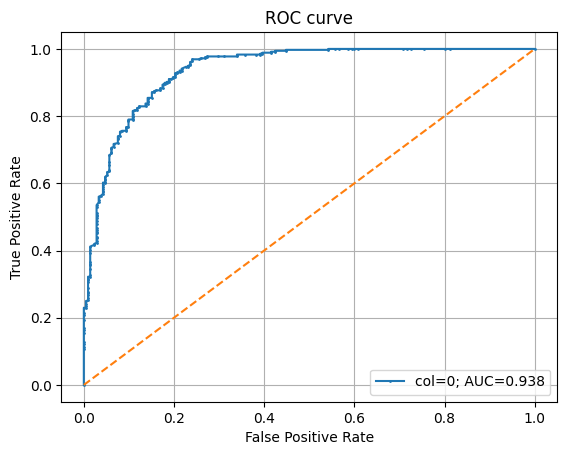

In [6]:
plot(X, y, 0)

In [7]:
def plot2(y, y_hat, x_max=1.0):
    fig, ax = plt.subplots()
    auc = roc_auc_score(y, y_hat)
    fpr, tpr, thresh = roc_curve(y, y_hat)
    ax.plot(fpr, tpr, label=f'AUC={auc:.3f}', marker='o', markersize=1)
    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

In [9]:
dts = list()
X_t = th.zeros_like(X).long()
for idx in range(X.shape[1]):
    dtc = DecisionTreeClassifier(max_leaf_nodes=10)
    dtc.fit(X[:,idx].reshape((-1,1)), y)
    dts.append(dtc)
    X_t[:,idx] = th.tensor(LabelEncoder().fit_transform(dtc.apply(X[:,idx].reshape((-1,1))))).long()

In [10]:
X.shape, X_t.shape

(torch.Size([569, 30]), torch.Size([569, 30]))

In [11]:
X_t

tensor([[1, 0, 1,  ..., 1, 0, 0],
        [1, 6, 1,  ..., 1, 9, 2],
        [1, 2, 1,  ..., 1, 0, 2],
        ...,
        [2, 8, 4,  ..., 9, 5, 7],
        [1, 8, 1,  ..., 1, 0, 0],
        [0, 3, 0,  ..., 0, 3, 7]])

In [12]:
impurities = list()
impurities_mean = list()
for idx, dt in enumerate(dts):
    t = dt.tree_
    impurities.append(t.impurity[t.feature<0]*t.n_node_samples[t.feature<0])
    impurities_mean.append(impurities[-1].mean())

In [13]:
aucs = list()
for idx in range(X.shape[1]):
    auc = roc_auc_score(y, X[:,idx])
    aucs.append(max(auc, 1-auc))

In [14]:
# top rated features
np.argsort(impurities_mean)

array([22, 23, 20, 27,  7,  2,  6,  3,  0, 13, 26, 12, 10,  5, 25, 16, 17,
       21,  1, 28, 24, 15,  4, 29,  8, 19,  9, 18, 14, 11])

In [15]:
topN = np.argsort(impurities_mean)[:5]#[-5::]
topN

array([22, 23, 20, 27,  7])

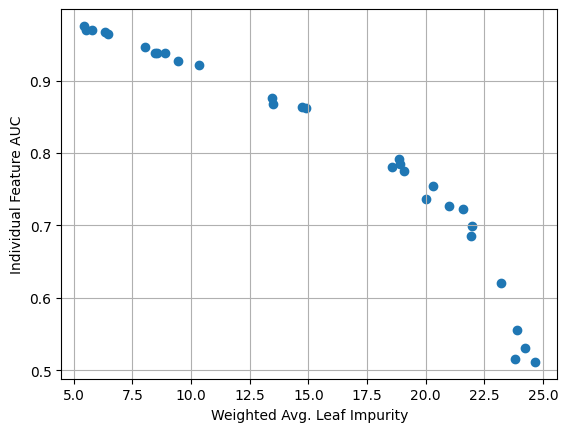

In [16]:
fig, ax = plt.subplots()
ax.scatter(impurities_mean, aucs)
ax.set(xlabel='Weighted Avg. Leaf Impurity', ylabel='Individual Feature AUC')
ax.grid()

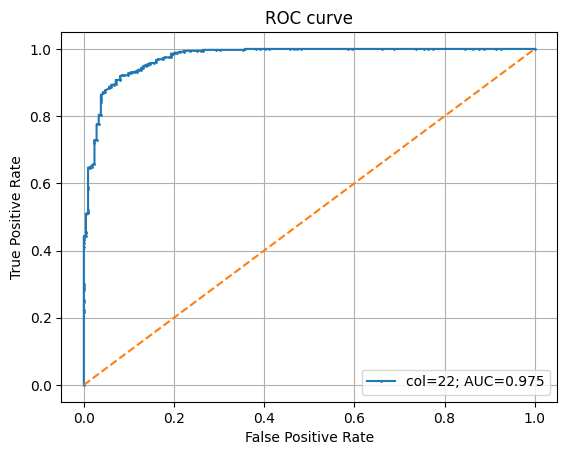

In [17]:
plot(X, y, 22)

In [18]:
class NumericEmbedding(nn.Module):
    def __init__(self, n_uniques, h_dim, agg_type='concat'):
        super().__init__()
        
        self.embeds = nn.ModuleList()
        for n_unique in n_uniques:
            self.embeds.append(
                nn.Embedding(n_unique, h_dim)
            )
        assert agg_type in ['concat', 'sum', 'mean']
        self.agg_type = agg_type
    
    def forward(self, X):
        hs = list()
        for idx, embed in enumerate(self.embeds):
            hs.append(embed(X[:,idx]))
        
        if self.agg_type=='concat':
            return th.hstack(hs)
        elif self.agg_type=='sum':
            return th.stack(hs, dim=2).sum(dim=2).squeeze()
        elif self.agg_type=='mean':
            return th.stack(hs, dim=2).mean(dim=2).squeeze()

In [19]:
(X_t.max(dim=0)[0]+1)

tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [20]:
n_uniques = (X_t[:,topN].max(dim=0)[0]+1).numpy()
num_embed = NumericEmbedding(n_uniques, 2, 'mean')

In [21]:
N_train = int(X.shape[0]*0.8)
X_train = X_t[:N_train,topN]
y_train = y[:N_train].float()
X_test = X_t[N_train:,topN]
y_test = y[N_train:].float()

In [22]:
model = nn.Sequential(NumericEmbedding(n_uniques, 16, 'sum'), nn.Linear(16, 1))

In [23]:
opt = optim.Adam(model.parameters(), lr=0.01)
train_losses = list()
test_losses = list()
for e in range(100):
    opt.zero_grad()
    logits = model(X_train)
    loss = F.binary_cross_entropy_with_logits(logits.flatten(), y_train)
    loss.backward()
    train_losses.append(loss.item())
    with th.no_grad():
        test_losses.append(
            F.binary_cross_entropy_with_logits(model(X_test).flatten(), y_test).item()
        )
    opt.step()

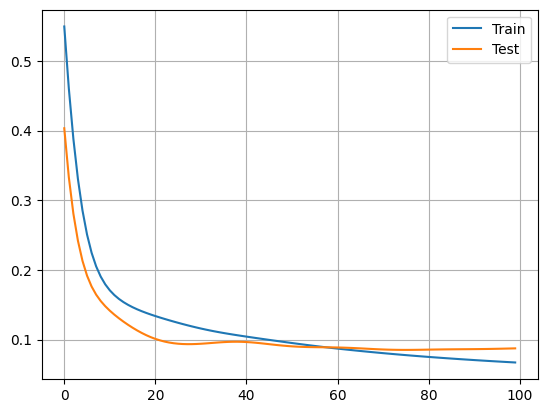

In [24]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(test_losses, label='Test')
ax.grid()
ax.legend()

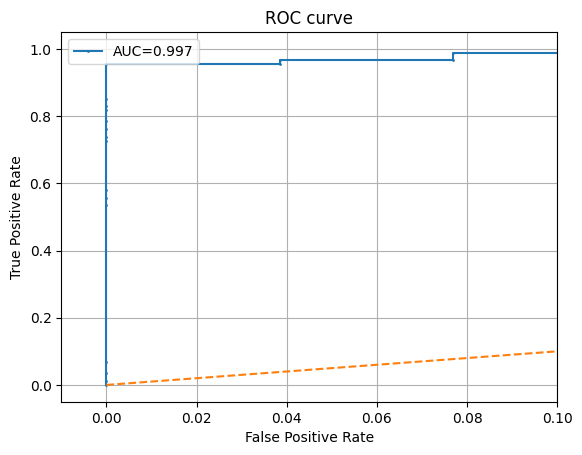

In [25]:
plot2(y_test,model(X_test).flatten().detach().numpy(), x_max=0.1)